<a href="https://colab.research.google.com/github/Hedredo/dagshub_p7/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Work in Progress**

**MLFlow**
- Ajouter une description aux runs mlflow
- Résoudre les dernières erreurs sur un run mlflow
- Ajouter en artifact la matrice de confusion et tester la fonction `plot_confusion_matrix` de `sklearn`
- Ajouter en artifact la courbe ROC et tester la fonction `plot_roc_curve` de `sklearn`
- Simplifier les appels aux différents paramètres et variables pour automatiser simplement le process
- Créer un pipeline pour le tfidf
- Créer une grille d'hyperparamètres pour le tfidf
- Créer une grille d'hyperparamètres pour le modèle
- Créer une fonction pour tester les différents modèles
- Créer une liste des architectures preprocessing + modèle + hyperparamètres
- Utiliser mflow.log_dict pour les hyperparamètres du preprocessing
- Finaliser la fonction de preprocessing avec des True/False pour les différentes étapes en match_case


**Modèle RN inspiré de KERAS**
- Créer un modèle de réseaux de neurones inspiré de KERAS

# **Configuration de l'environnement**

In [17]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import emoji
import re
from nltk.stem import SnowballStemmer
import time
from sklearn.preprocessing import LabelEncoder
from collections import namedtuple
from tqdm import tqdm
from typing import Union, List
import pickle

from utils.main import show_nums_axes

In [18]:
# Fonction pour vérifier si un token est un emoji
def is_emoji(token):
    return emoji.is_emoji(token.text)


# Fonction pour vérifier si un token est une mention
def is_mention(token):
    return re.match(r"@\w+", token.text) is not None

In [19]:
nlp_light = spacy.blank("en")

In [20]:
doc = nlp_light("Hello @world! 😊 this is my bro @goodguy ! :=)")

In [21]:
[token.text for token in doc if is_mention(token) or is_emoji(token)]

['@world', '😊', '@goodguy']

In [22]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize tdqm pandas
tqdm.pandas()

# **Lecture des données**

J'utilise le dataset open source `sentiment140` qui contient 1,6 millions de tweets annotés en 0 (négatif) ou 4 (positif).<br>
Le dataset est disponible sur Kaggle à l'adresse suivante : https://www.kaggle.com/kazanova/sentiment140


Je décide de lire tout le fichier à l'exception de la colonne `flag` qui contient la valeur unique **NO_QUERY**.

In [23]:
# Path to the csv file
path = "../data/raw/training.1600000.processed.noemoticon.csv"

# Read the file
df = pd.read_csv(
    path,
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"],
    usecols=["target", "ids", "date", "user", "text"],  # remove flag column
    parse_dates=["date"],
    encoding="utf-8",
    encoding_errors="replace",  # replace the errors with unicode symbol � (U+FFFD)
).sort_values(by="date", ascending=True)  # sort by date

# Display the info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 799999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB
None


On constate qu'il n'y a pas de valeurs nulles dans ce dataset.<br>

Voici un aperçu des données :

In [24]:
display(df.head(20))

,target,ids,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,2009-04-06 22:20:03,mybirch,Need a hug
7,0,1467811594,2009-04-06 22:20:03,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,2009-04-06 22:20:05,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,2009-04-06 22:20:09,mimismo,@twittera que me muera ?


# **Analyse pré-exploratoire et préparation des données**

Après avoir prévisualisé les données, je vais transformer les données afin de pouvoir les étudier plus facilement.

Les colonnes `ids` et `user` vont être encodées à l'aide d'un label encoder.<br>
Les modalités de la variable `target` sont ramenées à 1, pour les tweets positifs, et 0 pour les tweets négatifs.<br>
Enfin, la variable `date`est transformée en 3 champs : `month`, `day` et `hour`.

In [25]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the desired columns
for col in ["ids", "user"]:
    df[col] = encoder.fit_transform(df[col])

# Replace 4 with 1 in the target column
df["target"] = df["target"].replace(4, 1)

# Finally, create new columns for month, day, and hour and drop date
df = df.assign(
    **{
        "month": lambda x: x.date.progress_apply(lambda x: x.month),
        "day": lambda x: x.date.progress_apply(lambda x: x.day),
        "hour": lambda x: x.date.progress_apply(lambda x: x.hour),
    }
).drop(columns=["date"])

100%|██████████| 1600000/1600000 [00:02<00:00, 746553.89it/s] 


Enfin, je vais optimiser les types de données pour ces nouvelles variables.

In [26]:
# Convert the datatypes to save memory
df = df.astype(
    {
        "target": "int8",
        "ids": "int32",
        "user": "int32",
        "month": "int8",
        "day": "int8",
        "hour": "int8",
    }
)

In [27]:
# Display the data head to check the changes
df.head()

,target,ids,user,text,month,day,hour
0,0,0,242711,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,6,22
1,0,1,577449,is upset that he can't update his Facebook by ...,4,6,22
2,0,2,490699,@Kenichan I dived many times for the ball. Man...,4,6,22
3,0,3,65794,my whole body feels itchy and like its on fire,4,6,22
4,0,4,113308,"@nationwideclass no, it's not behaving at all....",4,6,22


**Vérification des duplicatas**

Je vérifie s'il y a des duplicatas dans le dataset de manière générale.<br>
Regardons plus précisemment si les colonnes ids, target et text contiennent des duplicatas.

In [28]:
print(df.duplicated().sum(), "duplicata trouvé.")
print(
    df.duplicated(subset=["ids", "target", "text"]).sum(),
    "duplicata trouvé sur les colonnes ids, target et text.",
)

0 duplicata trouvé.
0 duplicata trouvé sur les colonnes ids, target et text.


In [29]:
print("Nombre de tweets uniques: ", df["ids"].nunique())
print(
    "Nombre de tweets annotés à la fois positivement et négativement: ",
    df["ids"].size - df["ids"].nunique(),
)

Nombre de tweets uniques:  1598315
Nombre de tweets annotés à la fois positivement et négativement:  1685


Il est intérressant de constater que plusieurs tweets avec le même id ont été annotés différemment.<br>
Cela va introduire de l'incohérence lors de l'entraînement du modèle et affecter sa capacité à généraliser.<br>

Le plus simple est de retirer ces tweets du jeu d'entraînement.<br>
Regardons un exemple de tweet avec des valeurs différentes:

In [30]:
# Display 4 examples of duplicated rows with both positive and negative target
with pd.option_context("display.max_colwidth", 150):
    display(df.loc[df["ids"].duplicated(keep=False), ["text", "target"]].head(4))

,text,target
800261,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,1
213,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,0
800300,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",1
275,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",0


In [31]:
# Drop duplicates ids with both positive and negative target
df = df.drop_duplicates(subset=["ids"], keep=False)
print(
    "Nouvelle taille du jeu de données après suppression des duplicata sur ids: ",
    len(df),
)

Nouvelle taille du jeu de données après suppression des duplicata sur ids:  1596630


J'ai pu constaté qu'il n'y avait pas de valeur nulle dans le dataset donc nous n'effectuerons pas de vérification à ce sujet.<br>
Toutefois, une analyse sémantique des tweets avec de possibles valeurs interprétables comme "nulles" pourrait déceler des valeurs à supprimer.

# **Statistiques descriptives**

Dans un premier temps, vérifions la cohérence des variables numériques avec leurs statistiques descriptives:

In [32]:
# Display the summary statistics of numerical columns
with pd.option_context(
    "display.max_colwidth", 100, "display.float_format", "{:.2f}".format
):
    display(df.describe())

,target,ids,user,month,day,hour
count,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00
mean,0.50,799301.29,330323.25,5.51,14.81,10.96
std,0.50,461450.15,191341.79,0.61,9.79,7.22
min,0.00,0.00,0.00,4.00,1.00,0.00
25%,0.00,399669.25,164668.00,5.00,6.00,5.00
50%,0.50,799342.50,329997.00,6.00,16.00,10.00
75%,1.00,1199004.75,496888.75,6.00,21.00,18.00
max,1.00,1598314.00,659774.00,6.00,31.00,23.00


Rien d'anormal dans les statistiques descriptives des variables numériques.<br>
On constate que la période de temps est limité sur 3 mois.

In [33]:
# Statistics of the number of tweets per user
df["user"].value_counts().describe()

count    659502.000000
mean          2.420963
std           4.697115
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

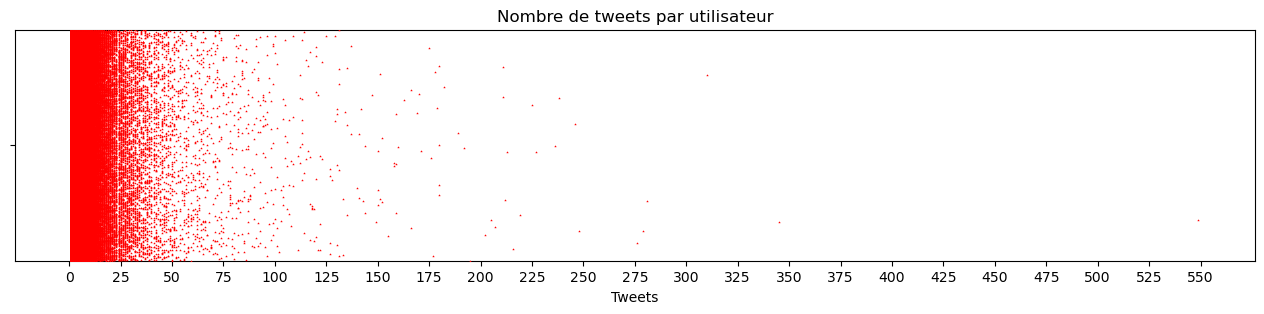

In [34]:
# Show a stripplot of the number of tweets per user
fig, ax = plt.subplots(figsize=(16, 3))
sns.stripplot(
    x=df["user"].value_counts(), jitter=0.5, size=2, marker="*", color="red", ax=ax
)
ax.set(title="Nombre de tweets par utilisateur", xlabel="Tweets")
ax.set_xticks(range(0, 575, 25))
plt.show()

En moyenne sur le jeu de données, on a 2,4 tweets par utilisateur unique.<br>
Certains utilisateurs sont très représentés dans le jeu de données avec un maximum de 549 tweets.

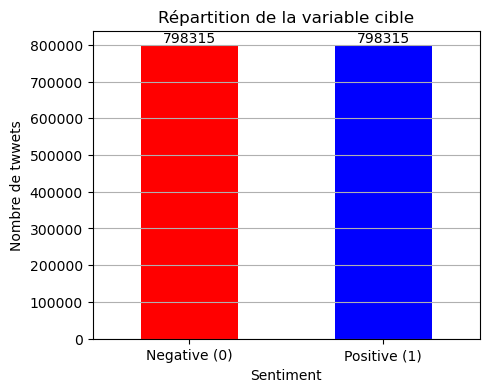

In [35]:
# Display a barplot of the number of tweets depending of the sentiment
fig, ax = plt.subplots(figsize=(5, 4))
df["target"].value_counts().plot(kind="bar", color=["red", "blue"], ax=ax).set(
    title="Répartition de la variable cible",
    xlabel="Sentiment",
    ylabel="Nombre de twwets",
)
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.grid(axis="y")
show_nums_axes(ax, fmt=".6g")
plt.show()

Le jeu de données présente un équilibre parfait entre les tweets positifs et négatifs.<br>
Cela nous assure une base équilibrée sur le jeu d'entraînement et de test.

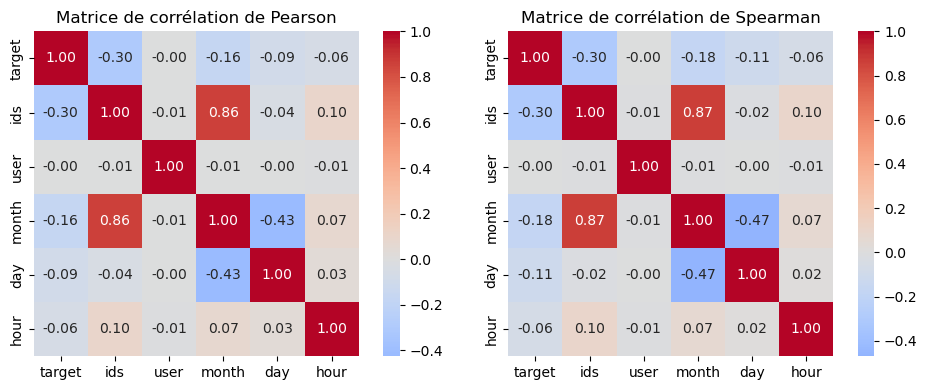

In [36]:
# Draw Pearson and Spearman correlation matrixes
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for axes, method in zip(ax.flatten(), ("pearson", "spearman")):
    sns.heatmap(
        df.select_dtypes(exclude=["object"]).corr(method=method),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        ax=axes,
    )
    axes.set_title(f"Matrice de corrélation de {method.capitalize()}")
plt.show()

Il n'y a pas de relation linéaire et/ou monotone entre les features numériques et la cible.<br>
Essayons de regarder si on peut détecter une relation entre les variables temporelles et la cible :

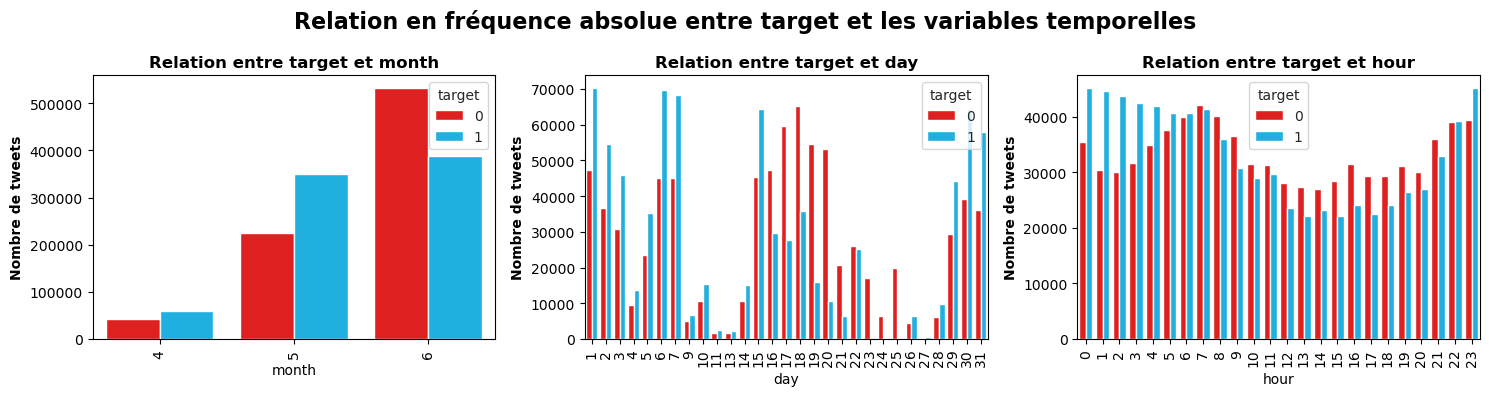

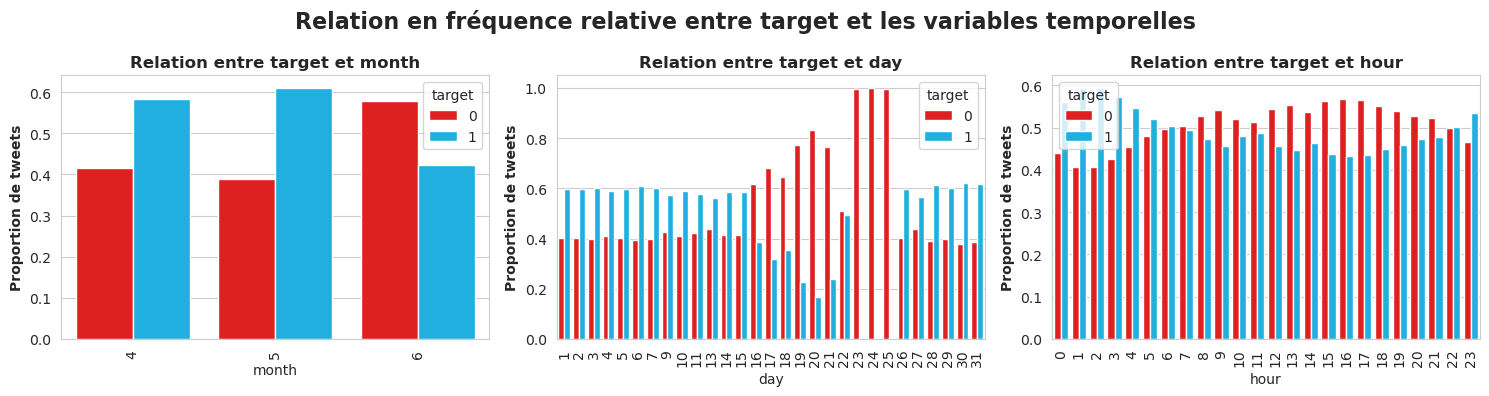

In [37]:
# Display the relation between target and the variables month, day, and hour
for title, method in zip(("absolue", "relative"), ("count", "proportion")):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False, tight_layout=True)
    fig.suptitle(
        f"Relation en fréquence {title} entre target et les variables temporelles",
        fontweight="bold",
        fontsize=16,
    )
    sns.set_style("whitegrid")
    for i, col in enumerate(["month", "day", "hour"]):
        sns.barplot(
            df.groupby(col)["target"]
            .value_counts(normalize=True if title == "relative" else False)
            .reset_index(),
            x=col,
            y=method,
            hue="target",
            palette=["red", "deepskyblue"],
            ax=ax[i],
        )
        ax[i].set_title(f"Relation entre target et {col}", fontweight="bold")
        ax[i].set_xlabel(col)
        ax[i].set_ylabel(
            "Proportion de tweets" if title == "relative" else "Nombre de tweets",
            fontweight="bold",
        )
        ax[i].set_xticks(ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    plt.show()

On peut noter que **certaines journées ne sont pas présentes (le 8 et le 12)**.<br>
Pour une raison inconnue, les jours 23, 24 et 25 sont uniquement **négatifs**.<br>
La répartition des tweets n'est pas uniforme **sur les mois**, avec une concentration beaucoup plus forte en mai (+ de positif) et en juin (+ de négatif) qu'en avril.<br>

On identifie deux relations non linéaires à:
- **l'échelle journalière**: Les tweets négatifs sont plus fréquents en milieu de mois et les tweets positifs en début et fin de mois.
- **l'échelle horaire**: On a deux courbes sinusoidale avec deux cycles différents pour les tweets positifs et négatifs. Celle-ci est vraiment intéressante et pourrait être exploitée pour la création de nouvelles features.

Dans l'absolu, **seule la variable horaire semble avoir un lien avec la target**.<br>
Je vais créer deux nouvelles features basées sur l'heure et les encodées de manière cyclique pour conserver la notion de périodicité et de continuité qui n'est pas capturé par un encodage one-hot ou ordinal.

In [38]:
# Création de deux variables transformées de l'heure avec un encodage cyclique
df = df.assign(
    **{
        "hour_sin": lambda x: np.sin(2 * np.pi * x.hour / 24),
        "hour_cos": lambda x: np.cos(2 * np.pi * x.hour / 24),
    }
)

In [39]:
df[["hour", "hour_sin", "hour_cos"]].describe()

,hour,hour_sin,hour_cos
count,1.596630e+06,1.596630e+06,1.596630e+06
mean,1.096383e+01,8.240894e-02,8.207023e-02
std,7.215811e+00,7.032419e-01,7.013734e-01
min,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.000000e+00,-5.000000e-01,-5.000000e-01
50%,1.000000e+01,2.588190e-01,2.588190e-01
75%,1.800000e+01,7.071068e-01,7.071068e-01
max,2.300000e+01,1.000000e+00,1.000000e+00


A présent, je vais étudier la structure des tweets sur le jeu de données.<br>
Commençons par avoir un aperçu d'une sélection de tweets aléatoires:

In [40]:
with pd.option_context("display.max_colwidth", 150):
    display(df[["text", "target"]].sample(25))

,text,target
1266561,"@tommcfly You and Dougie are great .. but in different ways. look on the brighter side, you're taller than he",1
806875,Made It Into Work This Morning Yay For Me.. It Looks As Though The Sun Was Attempting To Come Up With Me.. Maybe Next Week! GOOD MORNING!,1
1480666,going to get my Mac back!,1
1511969,@cmalesic Good luck in ur exam!! Cheers!,1
1111533,@BNichole8 UP AND SHAKING THE SLEEPY OFF!! HOT TEA.. IPHIZZY AND IM GOOD!!!,1
737512,Day 4 of the bridal shoot!! And its still raining out!,0
660789,Bringing my Girl to the Airport. She's going home to Vienna,0
1299431,@roborobb I call them gladiator sandals,1
611504,@stevecairney That's a bummer,0
1333117,"@ultraviolet__x yea, i kinda have the same impression. looks like they are flirting..",1


Le nom du jeu de données précise que les textes seraient sans emoticons.<br>
Sur ce sample, on constate que les tweets sont relativement courts et uniquement avec pas mal de mentions et quelques hashtags ainsi qu'une url.<br>
De plus, il n'est pas toujours évident de pouvoir classer certains tweets de part leur nature neutre.<br>
Calculons des statistiques pour vérifier ces observations:

In [41]:
# Create a new column for the length of the text
df = df.assign(
    **{
        "text_length": lambda x: x.text.str.len(),
    }
)
# Display the distribution statistics of the text length
print(df.groupby("target")["text_length"].describe())

           count       mean        std  min   25%   50%    75%    max
target                                                               
0       798315.0  74.226052  36.714397  6.0  44.0  69.0  104.0  188.0
1       798315.0  73.764481  36.052728  6.0  44.0  69.0  103.0  359.0


Ces premières statistiques nous confirment qu'il n'y a pas priori pas de tweets "vides" dans le jeu de données.<br>
Le minimum de caractères est de 6 dans ce jeu de données et il est nécessaire fixer un nombre minimum de caractères pour éviter les tweets vides.<br>

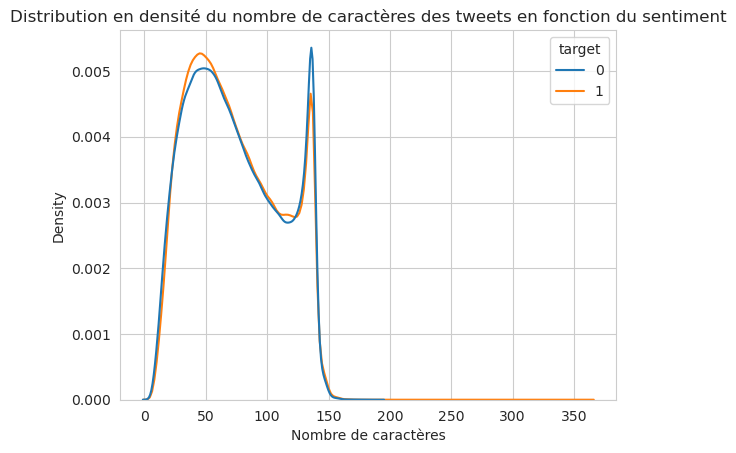

In [42]:
sns.kdeplot(df, x="text_length", color="red", hue="target")
plt.title(
    "Distribution en densité du nombre de caractères des tweets en fonction du sentiment"
)
plt.xlabel("Nombre de caractères")
plt.show()

La courbe de densité comparant les deux classes de sentiment montrent des distributions quasi-identiques.<br>
Les tweets positifs ont davantage de valeur extrêmes ce qui consistue l'unique différence.


Regardons à présent la ponctuation, les hashtags, les urls et les mentions dans les tweets:

In [43]:
# Create & compute the new features
df = df.assign(
    **{
        "punctuation_count": lambda x: x.text.str.count(r"[.!?]"),
        "hashtag_count": lambda x: x.text.str.count(r"#"),
        "mention_count": lambda x: x.text.str.count(r"@"),
        "url_count": lambda x: x.text.str.count(r"http|www"),
    }
)
# Display the summary statistics of the new features
df.filter(
    ["punctuation_count", "hashtag_count", "mention_count", "url_count", "target"]
).groupby("target").agg(["mean", "median", "std", "sum"])

punctuation_count                           hashtag_count         \
                    mean median       std      sum          mean median   
target                                                                    
0               2.035510    1.0  2.494771  1624978      0.023829    0.0   
1               2.028361    1.0  2.528746  1619271      0.032936    0.0   

                        mention_count                          url_count  \
             std    sum          mean median       std     sum      mean   
target                                                                     
0       0.197546  19023      0.402078    0.0  0.544104  320985  0.041851   
1       0.262481  26293      0.596132    1.0  0.624232  475901  0.074496   

                                
       median       std    sum  
target                          
0         0.0  0.217386  33410  
1         0.0  0.289478  59471

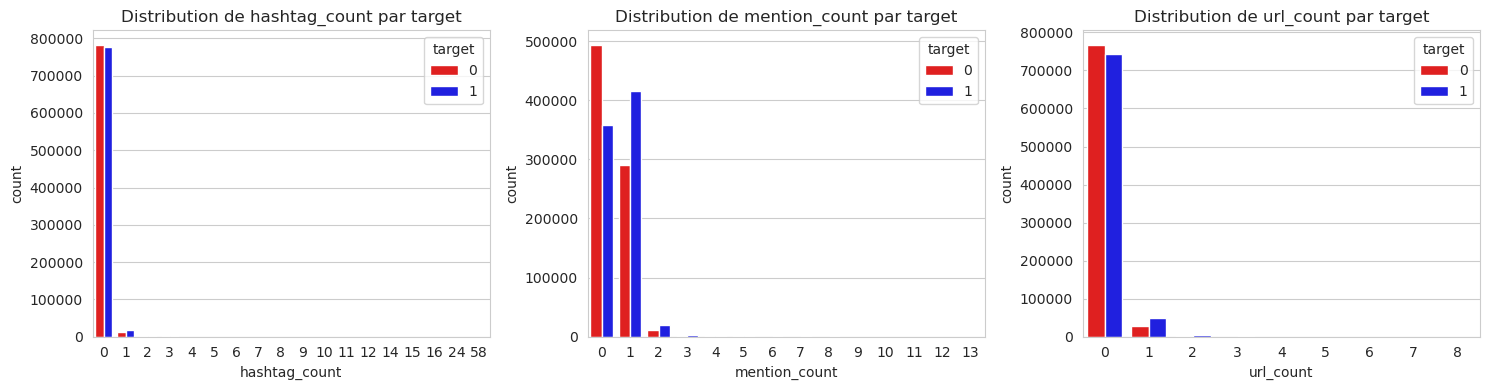

In [44]:
# Représentation de la distribution des nouvelles features discrètes
fig, ax = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for axes, feature in zip(ax.flatten(), ["hashtag_count", "mention_count", "url_count"]):
    sns.countplot(
        df.filter([feature, "target"]),
        x=feature,
        hue="target",
        palette=["red", "blue"],
        ax=axes,
    )
    axes.set_title(f"Distribution de {feature} par target")
plt.show()

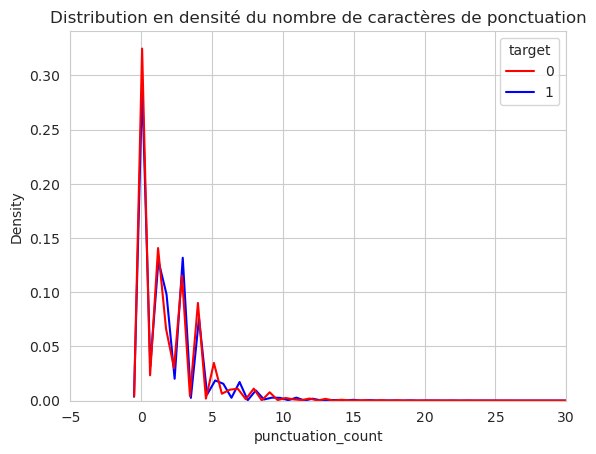

In [45]:
# Display the density distribution of the punctuation count
sns.kdeplot(
    df.filter(["punctuation_count", "target"]),
    x="punctuation_count",
    hue="target",
    palette=["red", "blue"],
).set(
    title="Distribution en densité du nombre de caractères de ponctuation",
    xlim=(-5, 30),
)
plt.show()

Regardons plus en détail les mentions, ce qu'elles contiennnent et l'influence sur la cible:

In [46]:
# Create a new column for the mentions identified in the text
df = df.assign(
    **{
        "first_mention": df["text"].str.lower().str.extract(r"(@\w+)"),
        "mentions": df["text"].str.lower().str.findall(r"(@\w+)"),
    }
)

In [47]:
import itertools
from collections import Counter

# Create a list of all mentions
all_mentions = list(itertools.chain(*df["mentions"].dropna().values))

# Display the most common mentions
counter = Counter(all_mentions)
print("Les 15 mentions les plus fréquentes:")
for mention, count in counter.most_common(15):
    print(f"{mention}: {count}")

Les 15 mentions les plus fréquentes:
@mileycyrus: 4544
@tommcfly: 3876
@ddlovato: 3464
@jonasbrothers: 2376
@davidarchie: 1378
@donniewahlberg: 1330
@jonathanrknight: 1260
@jordanknight: 1150
@mitchelmusso: 1097
@taylorswift13: 1026
@selenagomez: 805
@dougiemcfly: 792
@dannymcfly: 699
@peterfacinelli: 642
@aplusk: 625


In [48]:
len(counter)

343459

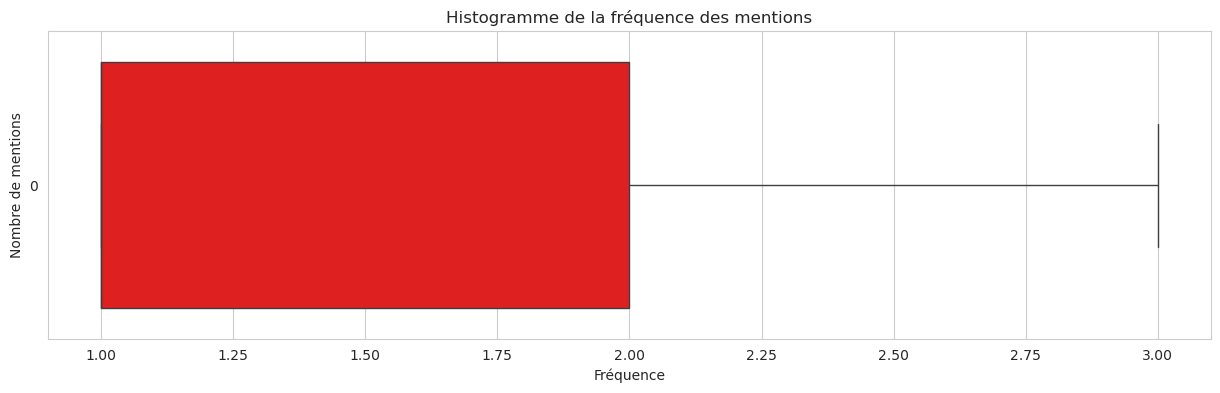

In [49]:
# Display the histogram of counter count
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(counter.values(), showfliers=False, color="red", orient="h", ax=ax)
ax.set_title("Histogramme de la fréquence des mentions")
ax.set_xlabel("Fréquence")
ax.set_ylabel("Nombre de mentions")
plt.show()

Regardons parmi les `first_mention`, leurs statistiques descriptives si certaines ont plus d'impact que d'autres mentions:

In [50]:
mention_df = (
    df.dropna(subset=["first_mention"])
    .groupby("target")["first_mention"]
    .value_counts()
)

print(mention_df.nlargest(10))

target  first_mention   
1       @mileycyrus         2950
        @tommcfly           2143
        @ddlovato           2004
0       @tommcfly           1611
1       @jonasbrothers      1547
0       @mileycyrus         1390
        @ddlovato           1251
1       @davidarchie         949
        @jonathanrknight     765
        @jordanknight        694
Name: count, dtype: int64


A première vue, on peut voir que certaines mentions ont davantage de tweets d'une classe ou d'une autre notamment parmi certaines celébrités populaires.<br>
Je vais calculer le nombre de mentions positives et négatives par mention unique.

In [51]:
# Compute the count of positive mentions
pos_mentions = (
    mention_df.reset_index()
    .loc[mention_df.reset_index()["target"] == 1, :]
    .set_index("first_mention")
)
# Compute the count of negative mentions
neg_mentions = (
    mention_df.reset_index()
    .loc[mention_df.reset_index()["target"] == 0, :]
    .set_index("first_mention")
).reindex(pos_mentions.index, fill_value=0)
# Check that the shapes and index are the same
assert neg_mentions.shape == pos_mentions.shape
assert neg_mentions.index.equals(pos_mentions.index)

Regardons ceux qui dominent le classement des mentions positives et négatives:

In [52]:
pos_mentions.head(5)

,target,count
first_mention,,
@mileycyrus,1,2950
@tommcfly,1,2143
@ddlovato,1,2004
@jonasbrothers,1,1547
@davidarchie,1,949


In [53]:
neg_mentions.head(5)

,target,count
first_mention,,
@mileycyrus,0,1390
@tommcfly,0,1611
@ddlovato,0,1251
@jonasbrothers,0,686
@davidarchie,0,368


In [54]:
# Create a dataframe computing the difference between positive and negative count for each unique mention divide by the sum of both count and multiply by 100
mention_ranking = (
    (
        pos_mentions["count"]
        .subtract(neg_mentions["count"])
        .div(pos_mentions["count"].add(neg_mentions["count"]))
        .mul(100)
    )
    .rename("diff_sentiment_pct")
    .to_frame()
    .merge(
        pos_mentions["count"]
        .add(neg_mentions["count"])
        .rename("tweet_counts")
        .to_frame(),
        left_index=True,
        right_index=True,
    )
)

Regardons à présent les statistiques descriptives de ce classement:

In [55]:
print(mention_ranking.describe())

       diff_sentiment_pct   tweet_counts
count       218101.000000  218101.000000
mean            73.952154       2.755146
std             45.070013      17.842885
min            -93.442623       1.000000
25%             50.000000       1.000000
50%            100.000000       1.000000
75%            100.000000       2.000000
max            100.000000    4340.000000


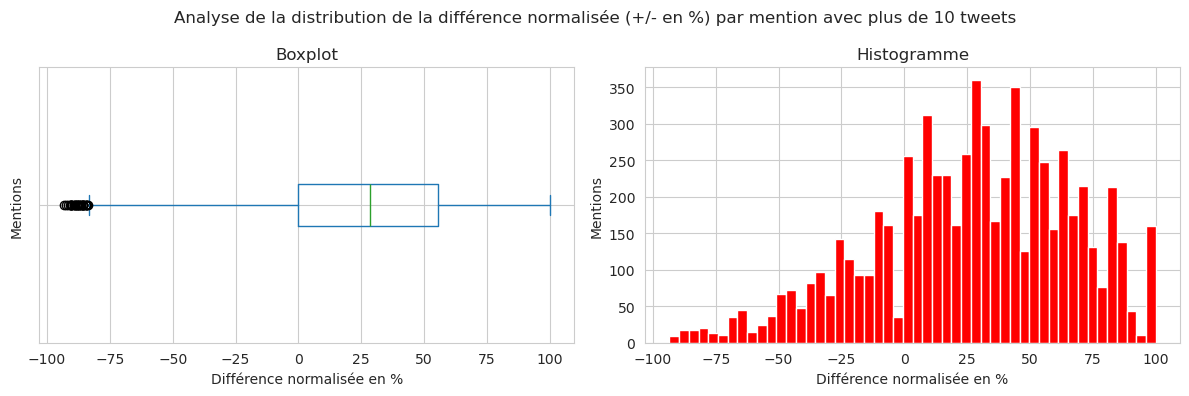

In [56]:
# Create a boxplot and histogram of the difference sentiment percentage
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
fig.suptitle(
    "Analyse de la distribution de la différence normalisée (+/- en %) par mention avec plus de 10 tweets",
)
# Filter mentions with more than 10 tweets and plot the boxplot and histogram
mention_ranking.loc[mention_ranking["tweet_counts"] > 10, "diff_sentiment_pct"].plot(
    kind="box", vert=False, ax=ax[0]
).set(
    title="Boxplot",
    xlabel="Différence normalisée en %",
    ylabel="Mentions",
)
ax[0].set_yticklabels([])
mention_ranking.loc[mention_ranking["tweet_counts"] > 10, "diff_sentiment_pct"].plot(
    kind="hist", bins=50, color="red", ax=ax[1]
).set(
    title="Histogramme",
    xlabel="Différence normalisée en %",
    ylabel="Mentions",
)
plt.show()

L'analyse de ces features ne montre pas de différence significative entre les tweets positifs et négatifs **excepté pour les mentions**.<br>
Les tweets positifs ont en moyenne plus de mentions que les tweets négatifs.


Quant **aux hashtags et urls**, leur présence dans les données sont en très petite proportion et sans différence significative sur la target.<br>
Dès lors, on peut les considérer comme du bruit et les inclure dans le nettoyage des données.


Concernant les **mentions**, on constate une différence entre ceux avec sans mentions et ceux avec des mentions.<br>
Vu la quantité de mentions dans le jeu de données et certaines avec un très haute fréquence, on peut tester avec ou sans pour voir si cela a un impact sur la performance du modèle.<br>
De plus, on peut toujours minimiser l'impact des mentions rares avec les paramètres des modèles.


Il nous reste d'autres éléments à analyser comme la distribution des tokens dans les tweets ainsi que la taille du vocabulaire.<br>
Préparons une version du texte nettoyé avec les éléments suivants:

In [57]:
df = df.assign(
    **{
        "mentionned": lambda x: x["mentions"].astype("bool").astype("int8"),
        "text_cleaned": lambda x: x["text"]
        .str.lower()  # lowercase the text
        .str.replace(r"http\S+|www\S+", " ", regex=True)  # remove urls
        .str.replace(r"#\w+", " ", regex=True)  # remove hashtags
        .str.replace(r"\s{2,}", " ", regex=True)  # strip multiple spaces
        .str.strip(),  # strip leading and trailing spaces
    }
)

In [58]:
df["text_cleaned"].sample(25)

461198     @cassandramaxine i love you... sorry about ear...
1370192    @lisasansouci of course. @nansan2 love the pic...
1045032    rt @iamthematrixfollow the matrix.........let'...
1501157    @billyraycyrus you should bring your whole fam...
923607                                  my healthy breakfast
1515969               @ahmnohere lol so did they deliver it?
1232158    @babblingbrookie the 'site cover' (uhhh, i don...
1103205                            that party was insaannnee
538319                                  it is so hot in here
1104569    @britneyspears @adamleber @joseomar @dizzybunn...
660109     @jenni_xd me too nothin' to do xd hows the new...
415505                    siiick being a bum watching movies
1134606    riding to east st to visit a friend. kid free....
1013973    @mastermarlowe look on my profile page and @pe...
1296420    @tommcfly of course you will win and you shoul...
1018186    good morning! it's friday and the beginning of...
1473713    so happy to b

Il y a deux choses que nous n'avons pas inspecter jusqu'à présent:
- la présence d'emojis dans les tweets (qui sont normalement absents)
- la langue des tweets (certains aperçus nous ont montré que d'autres langues pouvaient être présentes)


La présence des deux étant rarement apparus, on peut supposer qu'il s'agit d'un phénomène marginal.<br>
Concernant la présence d'autres langues, le coût de la détection et de la traduction des tweets n'est pas justifié par le gain potentiel.<br>
De plus, les modèles les plus avancés pré-entrainés, notamment à base de transformer, sont capables de gérer plusieurs langues sans traduction préalable.<br>


In [83]:
# Fonction pour vérifier si un token est un emoji
def is_emoji(token):
    return emoji.is_emoji(token.text)


# Fonction pour vérifier si un token est une mention
def is_mention(token):
    return re.match(r"@\w+", token.text) is not None

In [74]:
# Load a blank English model tokenizer
nlp_light = spacy.blank("en")

# Process a text with emojis
doc = nlp_light("@hello i don't know what to do with this !!!!!!!!!!!!!!! 😂")
print(" ".join([token.text for token in doc if is_emoji(token) or is_mention(token)]))

@hello 😂


Après avoir vérifier que le détecteur d'émojis fonctionne, je vais créer de nouvelles features afin d'inspecter la présence d'emojis dans les tweets.<br>
Je vais vérifier le nombre d'emojis unique.

In [65]:
emoji_count = []
emoji_counter = Counter()
# Process the texts
for text in tqdm(nlp_light.pipe(df["text_cleaned"])):
    # Tokenize the text
    emojis = [token.text for token in text if is_emoji(token)]
    emoji_count.append(len(emojis))
    emoji_counter.update(emojis)

1596630it [00:32, 48716.97it/s] 


In [69]:
print(sum(emoji_count), "emojis found in the dataset.")
print(emoji_counter.keys())

1864 emojis found in the dataset.
dict_keys(['♥', '®', '©', '♀', '☺', '™', '♦', '☮', '☎', '☀', '✔', '✈', '‼', '♠', '☹', '☃', '☂'])


In [68]:
emoji_counter.most_common(10)

[('♥', 1718),
 ('☺', 29),
 ('☮', 25),
 ('™', 19),
 ('®', 17),
 ('©', 15),
 ('♦', 8),
 ('♠', 8),
 ('☎', 7),
 ('☀', 4)]

Bien qu'on n'ait pas trouvé tant d'emojis que ça, on peut voir que les coeurs sont très présents et peuvent être un indicateur de sentiment positif.<br>
Regardons quelques exemples et la distribution pour vérifier notre hypothèse:

In [78]:
with pd.option_context("display.max_colwidth", 150):
    display(
        df[["text_cleaned", "target"]]
        .iloc[df["text_cleaned"].str.contains("♥").values]
        .sample(5)
    )

,text_cleaned,target
1326384,@empoweredandfit hiya there thanks for that - see the mountain - just climb it hugs♥,1
1561197,@therealtommyg haha i had a feeling it was gonna be that.. when you find out the datessss let a sistaaa know ♥ ya.,1
731052,dident die from the tornado ohh well lol♥,0
1258271,@selenagomez your fans r telling davit o call you look how leal r ur fans i loved you bye♥,1
396137,@rilgon i loooove jow. ♥ so please don't kill me.,0


Dans cet exemple, on peut supposer que les emojis ont eu un impact pour déterminer la classe de sentiment du tweet.<br>

Regardons de quelle manière leur présence est répartie dans les tweets positifs et négatifs:

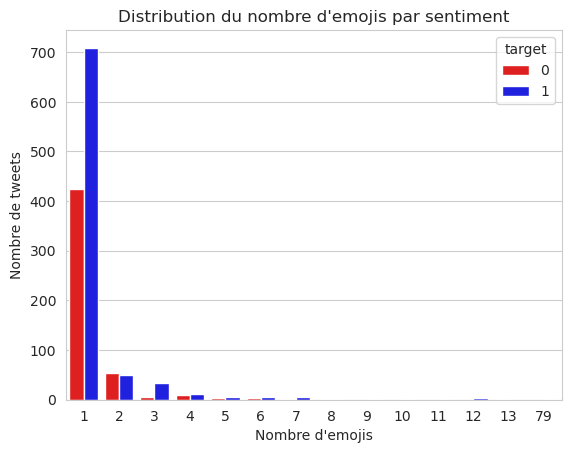

In [79]:
# Do add the emoji count to the dataframe
df = df.assign(**{"emoji_count": emoji_count})

# Display the distribution of the emoji count
df.loc[df["emoji_count"] > 0, ["emoji_count", "target"]].pipe(
    sns.countplot, x="emoji_count", hue="target", palette=["red", "blue"]
).set(
    title="Distribution du nombre d'emojis par sentiment",
    xlabel="Nombre d'emojis",
    ylabel="Nombre de tweets",
)
plt.show()

Il est difficile de tirer des conclusions sur la présence des emojis dans les tweets et leur impact sur le sentiment.<br>
Toutefois, on ne peut pas nier l'éventualité que les emojis aient un impact sur le sentiment des tweets.<br>
Comme leur nombre unique est très faible, on peut les laisser tels quels pour le moment sans que cela ne créent de problèmes de dimensionnalité.


A présent, nous allons conserver le texte sous différentes formes pour pouvoir comparer quels prétraitements sont les plus efficaces en fonction des modèles testés:
- `text` : jeu de données brutes
- `text_cleaned` : jeu de données en lowercase nettoyées des hashtags, urls, espaces multiples.
- `lemma` : jeu de données nettoyées sans ponctuation avec les lemmes des mots seulement alphanumériques (les emojis et mentions sont conservés)
- `stem` : jeu de données nettoyées sans ponctuation avec les racines des mots seulement alphanumériques (les emojis et mentions sont conservés)
- `lemma_nomention` : jeu de données nettoyées avec les racines des mots seulement alphanumériques et les lemmes des mots (les emojis sont conservés)
- `stem_nomention` : jeu de données nettoyées avec les racines des mots seulement alphanumériques et les lemmes des mots (les emojis sont conservés)

In [80]:
# Instantiate the english stemmer
stemmer = SnowballStemmer("english")

In [81]:
# Load the spacy model and disable the ner component
spacy_model = "en_core_web_sm"
disable = ["ner"]  # Only component to disable to get the best lemmatization

# Load the model without the ner component and download it if needed
try:
    nlp_lemma = spacy.load(spacy_model, disable=disable)
except OSError as e:
    print(e)
    print(f"Downloading the {spacy_model} model...")
    spacy.cli.download(spacy_model)
    # Add sleep time
    time.sleep(5)
    # Finally load the model
    print("Loading the model...")
    nlp_lemma = spacy.load(spacy_model, disable=disable)
finally:
    print(f"{spacy_model.upper()} model loaded successfully :)")
    print(f"Model components: {nlp_lemma.pipe_names}")

EN_CORE_WEB_SM model loaded successfully :)
Model components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


Pour faciliter le traitement et garder une trace des paramètres utilisés, je définis un namedtuple qui contient les paramètres de prétraitement des données ainsi que leur nom, qui sera également attribué aux colonnes créées:

In [84]:
# Define the named tuple
TokenParams = namedtuple(
    "TokenParams",
    ["name", "model_name", "model", "params"],
)

In [90]:
# Define every tokenization method to process the text
token_methods = [
    TokenParams(
        "lemma",
        "en_core_web_sm",
        nlp_lemma,
        (
            params := lambda doc: [
                token.text
                if is_emoji(token) or is_mention(token)
                else token.lemma_.lower()
                for token in doc
                if is_emoji(token)
                or is_mention(token)
                or not token.is_punct
                and not token.is_digit
            ]
        ),
    ),
    TokenParams(
        "stem",
        "blank_en",
        nlp_light,
        (
            params := lambda doc: [
                token.text
                if is_emoji(token) or is_mention(token)
                else stemmer.stem(token.text.lower())
                for token in doc
                if is_emoji(token)
                or is_mention(token)
                or not token.is_punct
                and not token.is_digit
            ]
        ),
    ),
    TokenParams(
        "lemma_nomention",
        "en_core_web_sm",
        nlp_lemma,
        (
            params := lambda doc: [
                token.text if is_emoji(token) else token.lemma_.lower()
                for token in doc
                if is_emoji(token)
                or not token.is_punct
                and not token.is_digit
                and not is_mention(token)
            ]
        ),
    ),
    TokenParams(
        "stem_nomention",
        "blank_en",
        nlp_light,
        (
            params := lambda doc: [
                token.text if is_emoji(token) else stemmer.stem(token.text.lower())
                for token in doc
                if is_emoji(token)
                or not token.is_punct
                and not token.is_digit
                and not is_mention(token)
            ]
        ),
    ),
]

In [91]:
# Create a function to preprocess the texts with spacy
def spacy_preprocess(
    texts: Union[List[str], np.ndarray, pd.Series], TokenParams: namedtuple
) -> list:
    """
    Preprocess a list of texts using the spacy model and the tokenizer
    """
    assert isinstance(
        texts, (list, np.ndarray, pd.Series)
    ), "The input must be a sequence (list, array or series) of texts."
    preprocessed_texts = []
    # Process the texts
    for text in tqdm(TokenParams.model.pipe(texts)):
        # Tokenize the text
        tokens = TokenParams.params(text)
        preprocessed_texts.append(" ".join(tokens))
    return preprocessed_texts

Je vais maintenant finaliser la création des corpus :

In [92]:
for token_method in token_methods:
    df[token_method.name] = spacy_preprocess(df["text_cleaned"], token_method)

1596630it [15:17, 1739.49it/s]
1596630it [02:52, 9254.86it/s] 
1596630it [15:10, 1753.97it/s]
1596630it [02:36, 10171.44it/s]


On peut constater que le traitement avec les lemmes est plus long car les composantes du pipeline sont plus nombreuses et demandent davantage de temps de traitement.<br>
A présent, nous allons filtrer les colonnes que nous voulons uniquement conserver pour la phase de modélisation.

In [93]:
df.columns

Index(['target', 'ids', 'user', 'text', 'month', 'day', 'hour', 'hour_sin',
       'hour_cos', 'text_length', 'punctuation_count', 'hashtag_count',
       'mention_count', 'url_count', 'first_mention', 'mentions', 'mentionned',
       'text_cleaned', 'emoji_count', 'lemma', 'stem', 'lemma_nomention',
       'stem_nomention'],
      dtype='object')

In [94]:
df.filter(
    [
        "target",
        "hour_sin",
        "hour_cos",
        "text",
        "text_cleaned",
        "lemma",
        "stem",
        "lemma_nomention",
        "stem_nomention",
    ]
).sample(10)

,target,hour_sin,hour_cos,text,text_cleaned,lemma,stem,lemma_nomention,stem_nomention
1558334,1,-0.965926,-2.588190e-01,@AMcLame Send me a picture and I'll do it for ...,@amclame send me a picture and i'll do it for ...,@amclame send i a picture and i will do it for...,@amclame send me a pictur and i ll do it for y...,send i a picture and i will do it for you haha,send me a pictur and i ll do it for you haha
911738,1,-0.866025,5.000000e-01,@androidtomato Hello Gorgeous GIRL! Nice new p...,@androidtomato hello gorgeous girl! nice new p...,@androidtomato hello gorgeous girl nice new pi...,@androidtomato hello gorgeous girl nice new pi...,hello gorgeous girl nice new pic how be you today,hello gorgeous girl nice new pic how are you t...
1192012,1,-0.500000,-8.660254e-01,@OldDirtyBtard ok that kool then,@olddirtybtard ok that kool then,@olddirtybtard ok that kool then,@olddirtybtard ok that kool then,ok that kool then,ok that kool then
1205382,1,-1.000000,-1.836970e-16,setting the Twilight kiss to &quot;I wanna mak...,setting the twilight kiss to &quot;i wanna mak...,set the twilight kiss to quot;i wanna make lov...,set the twilight kiss to quot;i wanna make lov...,set the twilight kiss to quot;i wanna make lov...,set the twilight kiss to quot;i wanna make lov...
793271,0,0.965926,-2.588190e-01,@211me no love for canada...usa citizens only,@211me no love for canada...usa citizens only,@211me no love for canada usa citizen only,@211me no love for canada usa citizen onli,no love for canada usa citizen only,no love for canada usa citizen onli
236447,0,0.965926,2.588190e-01,@joyfulfortress aww i would so become a veget...,@joyfulfortress aww i would so become a vegeta...,@joyfulfortress aww i would so become a vegeta...,@joyfulfortress aww i would so becom a vegetarian,aww i would so become a vegetarian,aww i would so becom a vegetarian
558336,0,0.500000,8.660254e-01,just had my last ever exam lastday ofschool. ...,just had my last ever exam lastday ofschool. i...,just have my last ever exam lastday ofschool i...,just had my last ever exam lastday ofschool i ...,just have my last ever exam lastday ofschool i...,just had my last ever exam lastday ofschool i ...
514993,0,0.707107,7.071068e-01,@gamy_fitz where is ur new house? hope the mov...,@gamy_fitz where is ur new house? hope the mov...,@gamy_fitz where be ur new house hope the move...,@gamy_fitz where is ur new hous hope the move ...,where be ur new house hope the move go ok i be...,where is ur new hous hope the move went ok i '...
1213618,1,0.258819,9.659258e-01,*editing some NEW photos. Late aft lovies.,*editing some new photos. late aft lovies.,edit some new photo late aft lovie,edit some new photo late aft lovi,edit some new photo late aft lovie,edit some new photo late aft lovi
1208313,1,-0.258819,9.659258e-01,@djmainevent,@djmainevent,@djmainevent,@djmainevent,,


In [95]:
# Save the preprocessed dataframe as a parquet file
filtered_cols = [
    "target",
    "hour_sin",
    "hour_cos",
    "text",
    "text_cleaned",
    "lemma",
    "stem",
    "lemma_nomention",
    "stem_nomention",
]

# Save the preprocessed dataframe
df.filter(filtered_cols).to_parquet("../data/processed/df_preprocessed.parquet")
# Save the columns names in a pickle file
with open("../data/processed/columns.pkl", "wb") as f:
    pickle.dump(filtered_cols, f)